In [1]:
import sys
import os
import subprocess
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
import cv2
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import regularizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/sunchenxi/Desktop/lab/kaggle/amazon/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/sunchenxi/Desktop/lab/kaggle/amazon/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)
#读取train set标签
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

In [4]:
#获取含有tags标签的n张图片
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]
#获取不含含有tags标签的n张图片
def not_sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 0
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    print('Load failed: could not find image {}'.format(path))
 
 #将图片在数组中的位置变成名称
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

In [5]:
n=0
for i in range(len(labels_df)):
    if(labels_df['agriculture'][i]==1):
        n=n+1
fname=[0]*n
s = sample_images(['agriculture'], n=n)
for i in range(n):
    fname[i]= sample_to_fname(s, i)#获得了文件名
agriculture_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname[:300]]
n1=0
for i in range(len(labels_df)):
    if(labels_df['agriculture'][i]==0):
        n1=n1+1
fname_not=[0]*n1
s = not_sample_images(['agriculture'], n=n)
for i in range(n):
    fname_not[i]= sample_to_fname(s, i)#获得了文件名
not_agriculture_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname_not[:300]]
images=agriculture_img+not_agriculture_img
resized_images = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA), [1,64,64,4]) for img in images]

In [6]:
fname

['train_5596.jpg',
 'train_8634.jpg',
 'train_3008.jpg',
 'train_23023.jpg',
 'train_6734.jpg',
 'train_4452.jpg',
 'train_17964.jpg',
 'train_17488.jpg',
 'train_12379.jpg',
 'train_6609.jpg',
 'train_5660.jpg',
 'train_27425.jpg',
 'train_17383.jpg',
 'train_8392.jpg',
 'train_17806.jpg',
 'train_19857.jpg',
 'train_38255.jpg',
 'train_36102.jpg',
 'train_3685.jpg',
 'train_1926.jpg',
 'train_17387.jpg',
 'train_38538.jpg',
 'train_148.jpg',
 'train_24120.jpg',
 'train_21920.jpg',
 'train_22459.jpg',
 'train_10735.jpg',
 'train_2690.jpg',
 'train_32486.jpg',
 'train_20038.jpg',
 'train_35286.jpg',
 'train_8248.jpg',
 'train_12674.jpg',
 'train_19147.jpg',
 'train_40089.jpg',
 'train_23501.jpg',
 'train_35870.jpg',
 'train_19135.jpg',
 'train_599.jpg',
 'train_25447.jpg',
 'train_32484.jpg',
 'train_20002.jpg',
 'train_23071.jpg',
 'train_16663.jpg',
 'train_30218.jpg',
 'train_38828.jpg',
 'train_24268.jpg',
 'train_33862.jpg',
 'train_6638.jpg',
 'train_15659.jpg',
 'train_24546.jpg

In [33]:
agriculture_label=[0]*300
non_agriculture_label=[1]*300
labels=agriculture_label+non_agriculture_label

In [35]:
Y_test = np_utils.to_categorical(labels, 2)  

In [36]:
Y_test

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [37]:
train_x = np.vstack(resized_images)
train_y = Y_test

In [39]:
train_x.shape

(600, 64, 64, 4)

In [41]:
op = RMSprop(lr=0.0001)
ob = 'binary_crossentropy'
def Cnet():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(64, 64, 4), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Convolution2D(64, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    
    model.add(Convolution2D(128, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))
    
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss=ob, optimizer=op, metrics=['accuracy'])
    return model


model = Cnet()


model = Cnet()
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model.fit(train_x, train_y, batch_size=32, epochs=10,validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 4...)`
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (4, 4), padding="same", activation="relu")`
  app.launch_new_instance()


Train on 450 samples, validate on 150 samples
Epoch 1/10
450/450 [==============================] - 11s - loss: 179.8088 - acc: 0.6511 - val_loss: 185.9443 - val_acc: 0.0000e+00
Epoch 2/10
450/450 [==============================] - 9s - loss: 172.1508 - acc: 0.6667 - val_loss: 178.8694 - val_acc: 0.0000e+00
Epoch 3/10
450/450 [==============================] - 9s - loss: 165.1278 - acc: 0.6667 - val_loss: 171.8390 - val_acc: 0.0000e+00
Epoch 4/10
450/450 [==============================] - 9s - loss: 158.0634 - acc: 0.6667 - val_loss: 164.7422 - val_acc: 0.0000e+00
Epoch 5/10
450/450 [==============================] - 10s - loss: 150.9717 - acc: 0.6667 - val_loss: 157.6818 - val_acc: 0.0000e+00
Epoch 6/10
450/450 [==============================] - 11s - loss: 143.9664 - acc: 0.6667 - val_loss: 150.7643 - val_acc: 0.0000e+00
Epoch 7/10
450/450 [==============================] - 10s - loss: 137.1333 - acc: 0.6667 - val_loss: 144.0475 - val_acc: 0.0000e+00
Epoch 8/10
450/450 [=============

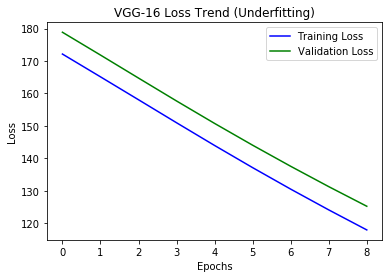

In [42]:
loss = history.losses
val_loss = history.val_losses
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Underfitting)')
plt.plot(loss[1:], 'blue', label='Training Loss')
plt.plot(val_loss[1:], 'green', label='Validation Loss')
plt.legend()
plt.show()

In [46]:
 a=model.predict_classes (train_x[0:400])

400/400 [==============================] - 3s     


In [47]:
a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,